<a href="https://colab.research.google.com/github/GangaMegha/Digital-Image-Processsing/blob/main/Image_Haftoning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Halftoning

The lab document can be found at : https://cabouman.github.io/grad_labs/Image-Halftoning/index.html

The ipython notebook is available at : https://github.com/GangaMegha/Digital-Image-Processsing

# 3.1 Exercise : Thresholding

In [ ]:
# Download input image
!wget https://cabouman.github.io/grad_labs/data/house.zip
!unzip -qq house.zip
!rm -r house.zip

--2022-04-22 01:33:38--  https://cabouman.github.io/grad_labs/data/house.zip
Resolving cabouman.github.io (cabouman.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to cabouman.github.io (cabouman.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82015 (80K) [application/zip]
Saving to: ‘house.zip’

house.zip           100%[===================>]  80.09K  --.-KB/s    in 0.01s   

2022-04-22 01:33:38 (6.18 MB/s) - ‘house.zip’ saved [82015/82015]



In [ ]:
# Read image
from PIL import Image
import numpy as np

img_gray = np.asarray(Image.open("house.tif"))*1.0

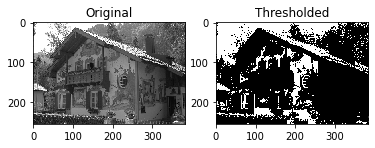

In [ ]:
import matplotlib.pyplot as plt

# Apply threshold and make it binary
T = 127

img_bin = img_gray.copy()
img_bin[img_bin>T] = 255.0
img_bin[img_bin<=T] = 0.0

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(img_gray, interpolation="none", cmap="gray")
ax[0].set_title("Original")
ax[1].imshow(img_bin, interpolation="none", cmap="gray")
ax[1].set_title("Thresholded")
plt.savefig("Theshold.png", dpi=300)
plt.show()

In [ ]:
# Compute the root mean square error (RMSE) between the original and binary images
def compute_RMSE(img1, img2):
  return np.sqrt(1.0/(img1.shape[0]*img1.shape[1]) * np.sum((img2-img1)**2))

print("RMSE : ", compute_RMSE(img_bin, img_gray))

RMSE :  87.3933165438293


In [ ]:
from scipy.signal import convolve2d

def compute_fidelity(img1, img2):
  # Un-Gamma correct the 2 input images (γ = 2.2)
  gamma1 = 2.2
  img1 = 255.0*((img1/255.0)**gamma1)
  img2 = 255.0*((img2/255.0)**gamma1)

  # Filter the image using Gaussian filter
  kernel_size = 7
  sigma_sq = 2
  filter = np.ones((kernel_size, kernel_size))
  for i in range(kernel_size):
    for j in range(kernel_size):
      filter[i,j] = np.exp(-1.0*(((i-3)**2 + (j-3)**2)/(2*sigma_sq)))
  filter /= np.sum(filter)

  img1 = convolve2d(img1, filter, mode="same")  
  img2 = convolve2d(img2, filter, mode="same")  

  # Gamma correct
  gamma2 = 3
  img1 = 255.0*((img1/255.0)**(1.0/gamma2))
  img2 = 255.0*((img2/255.0)**(1.0/gamma2))

  return compute_RMSE(img1, img2)

print("Fidelity : ", compute_fidelity(img_bin, img_gray))

Fidelity :  77.33714917243346


# 4 Ordered Dithering

In [ ]:
# Un-Gamma correct the 2 input images (γ = 2.2)
gamma1 = 2.2
img_gray_lin = 255.0*((img_gray/255.0)**gamma1)

# Create Bayer threshold matrices
def create_bayer_matrix(N):
  I2 = np.array([[1,2], [3, 0]])
  I2n = np.zeros((N, N))
  
  if N==2:
    return I2
  elif N>2:
    In = create_bayer_matrix(N//2)
    n = N//2
    for i in range(2):
      for j in range(2):
        I2n[i*n:(i+1)*n, j*n: (j+1)*n] = 4*In+I2[i,j]

  return I2n

I2 = create_bayer_matrix(N=2)
print("I2 : \n", I2)
I4 = create_bayer_matrix(N=4)
print("\n\nI4 : \n", I4)
I8 = create_bayer_matrix(N=8)
print("\n\nI8 : \n", I8)


I2 : 
 [[1 2]
 [3 0]]


I4 : 
 [[ 5.  9.  6. 10.]
 [13.  1. 14.  2.]
 [ 7. 11.  4.  8.]
 [15.  3. 12.  0.]]


I8 : 
 [[21. 37. 25. 41. 22. 38. 26. 42.]
 [53.  5. 57.  9. 54.  6. 58. 10.]
 [29. 45. 17. 33. 30. 46. 18. 34.]
 [61. 13. 49.  1. 62. 14. 50.  2.]
 [23. 39. 27. 43. 20. 36. 24. 40.]
 [55.  7. 59. 11. 52.  4. 56.  8.]
 [31. 47. 19. 35. 28. 44. 16. 32.]
 [63. 15. 51.  3. 60. 12. 48.  0.]]


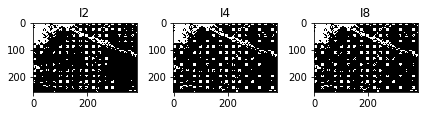

In [ ]:
# Get Halftone Image
def generate_halftone(img, In):
  N = In.shape[0]

  # Generate Threshold matrix
  T = 255.0 * (In+0.5) / (N**2)

  # Apply T to image
  img_bin = np.zeros_like(img)
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if img[i,j]>T[i%N, j%N]:
        img_bin[i,j] = 255

  return img_bin

fig, ax = plt.subplots(nrows=1, ncols=3)
img_2 = generate_halftone(img_gray_lin, I2)
ax[0].imshow(img_2, interpolation="none", cmap="gray")
ax[0].set_title("I2")
img_4 = generate_halftone(img_gray_lin, I4)
ax[1].imshow(img_4, interpolation="none", cmap="gray")
ax[1].set_title("I4")
img_8 = generate_halftone(img_gray_lin, I8)
ax[2].imshow(img_8, interpolation="none", cmap="gray")
ax[2].set_title("I8")
plt.tight_layout()
plt.savefig("Halftone.png", dpi=500)

The images look like :  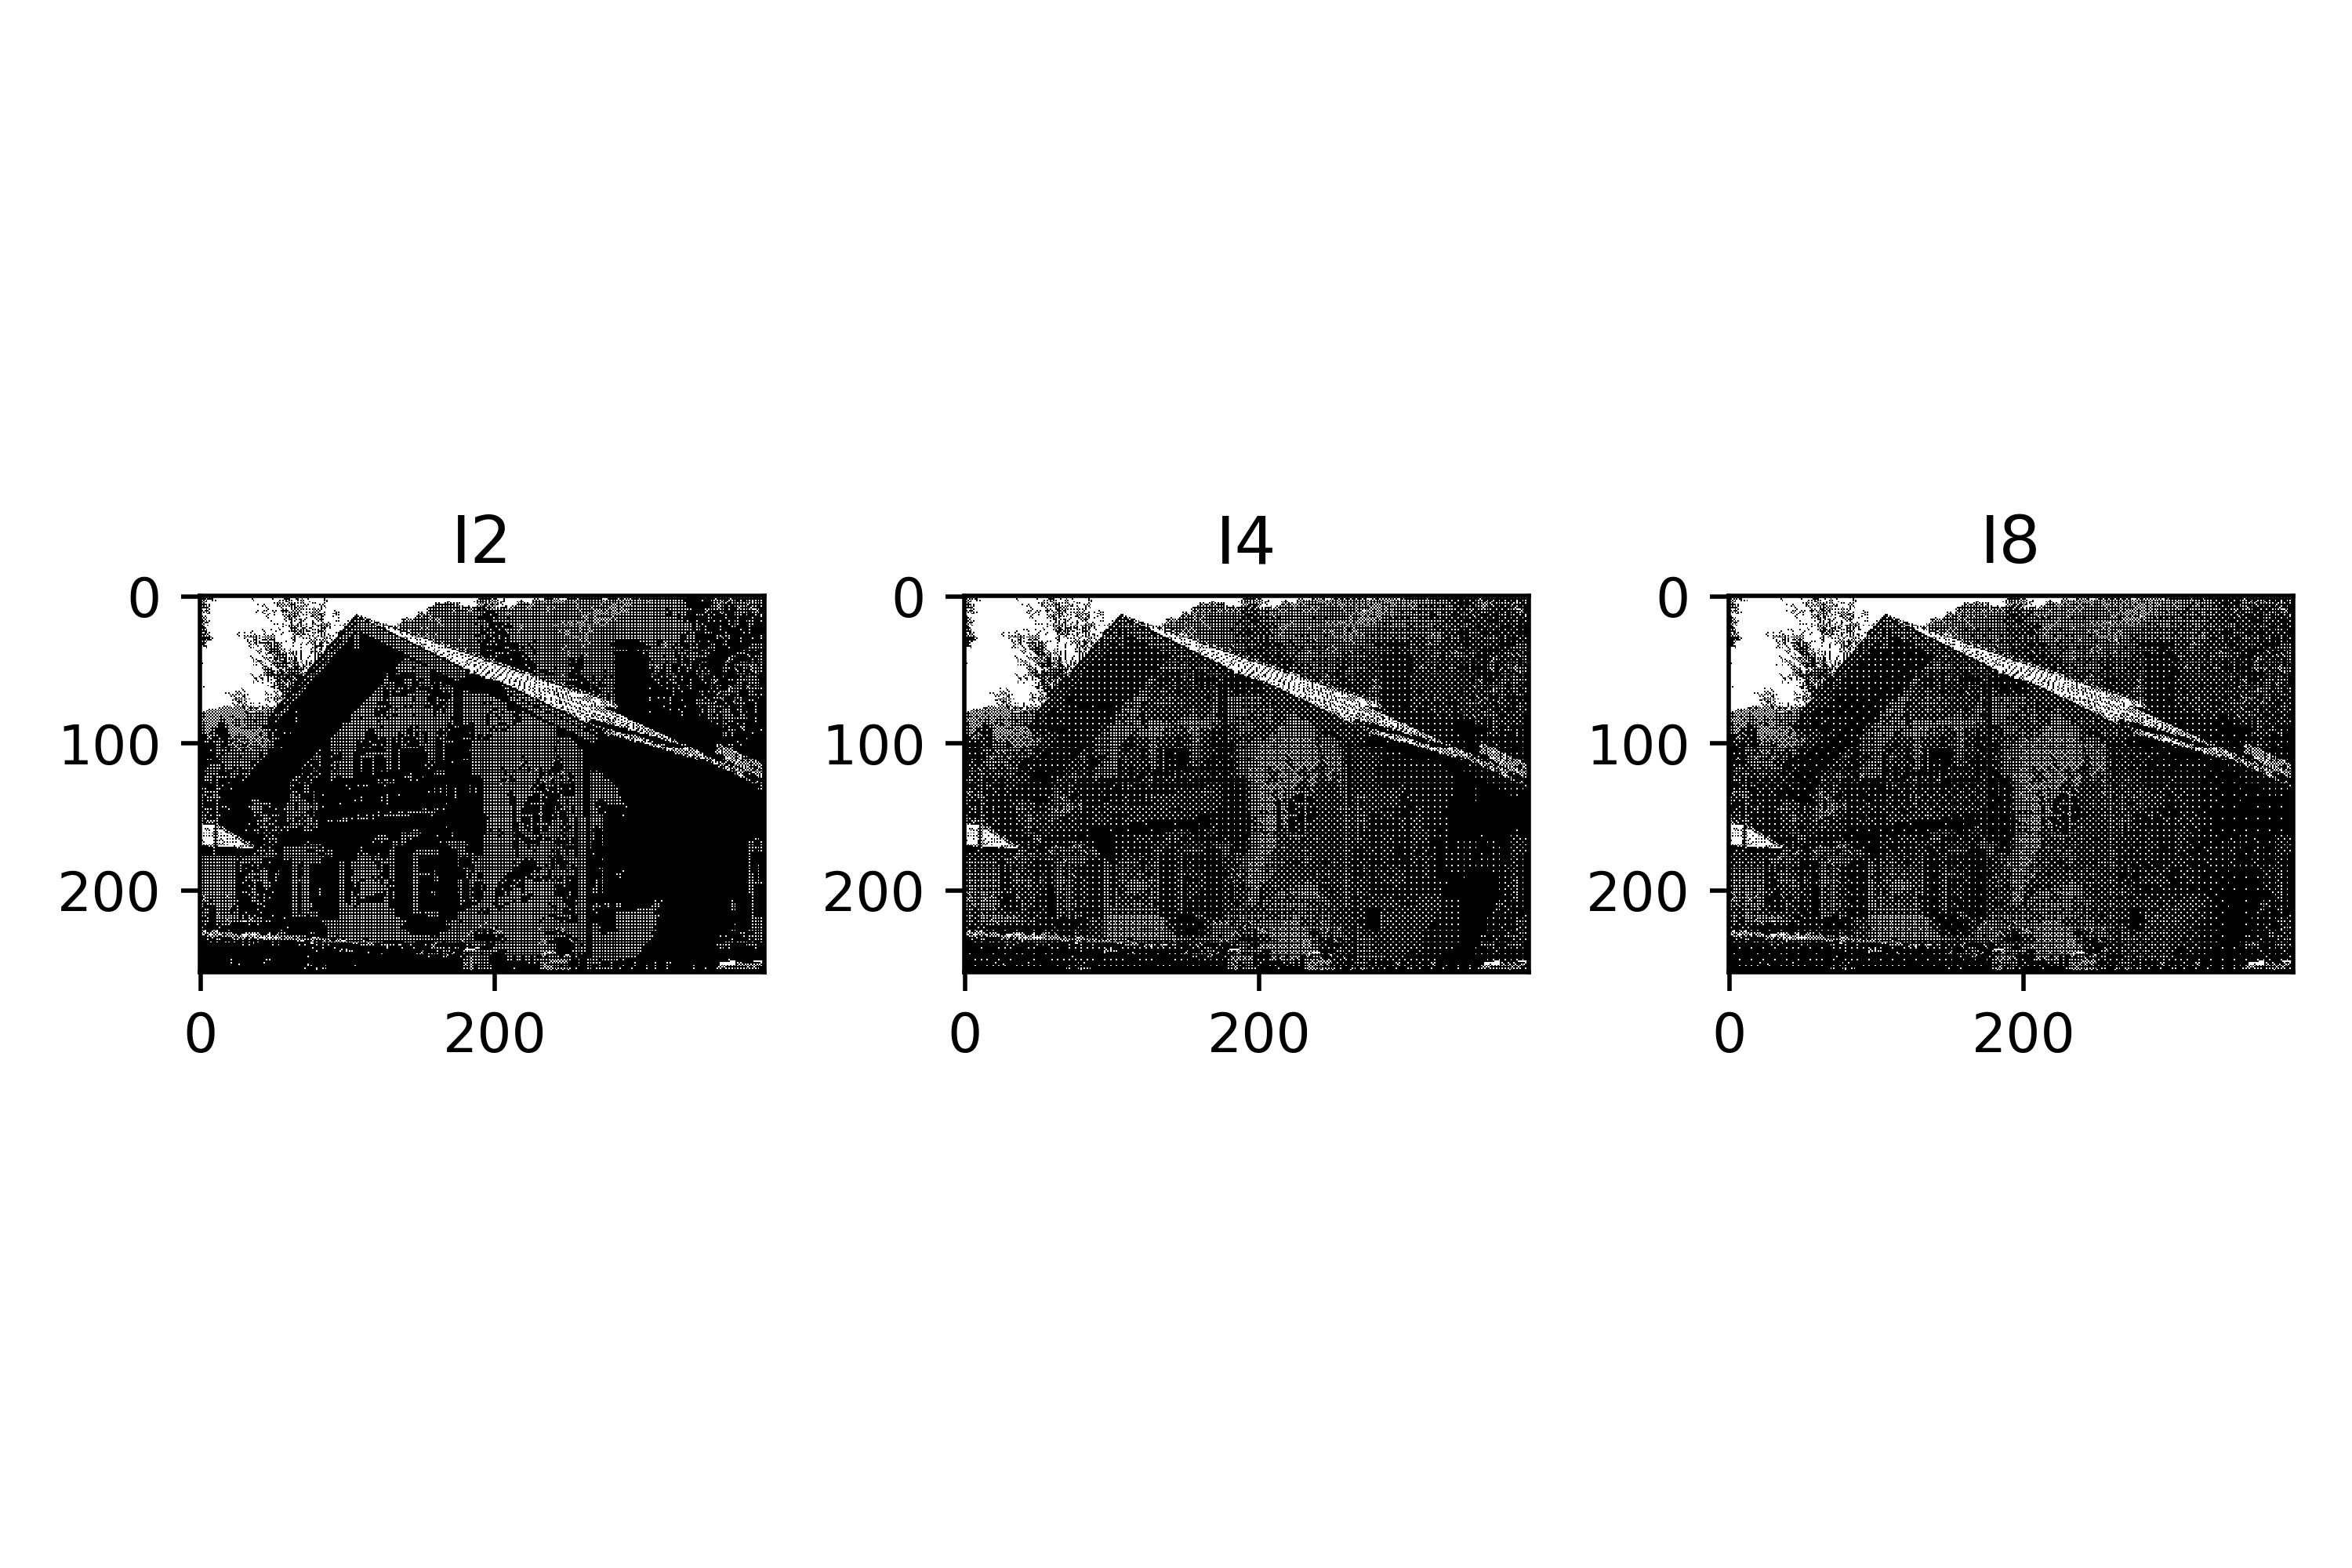

In [ ]:
# Compute RMSE and Fidelity
print("RMSE for I2 : ", compute_RMSE(img_2, img_gray))
print("Fidelity for I2 : ", compute_fidelity(img_2, img_gray))

print("\n\nRMSE for I4 : ", compute_RMSE(img_4, img_gray))
print("Fidelity for I4 : ", compute_fidelity(img_4, img_gray))

print("\n\nRMSE for I8 : ", compute_RMSE(img_8, img_gray))
print("Fidelity for I8 : ", compute_fidelity(img_8, img_gray))

RMSE for I2 :  97.66897219213996
Fidelity for I2 :  50.05694796030144


RMSE for I4 :  101.00692201569473
Fidelity for I4 :  16.558342510690387


RMSE for I8 :  100.91452962396079
Fidelity for I8 :  14.691773433816369


# 5 Error Diffusion

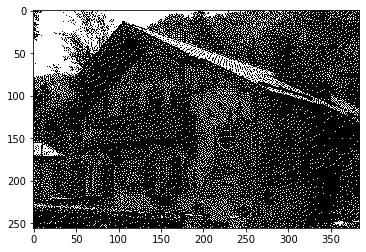

In [ ]:
# Initialize an output image matrix with zeros
out_img = np.zeros_like(img_gray_lin)
img = img_gray_lin.copy()

# Given Threshold
T = 127


for i in range(img.shape[0]):
  for j in range(img.shape[1]):
    if img[i,j]>T:
      out_img[i,j] = 255
      
    # Compute the quantization error by subtracting the binary pixel from the grayscale pixel
    e = img[i,j] - out_img[i,j]
    
    h = np.array([[0, 0, 7.0/16], [3.0/16, 5.0/16, 1.0/16]])
    if(j+1<img.shape[1]):
      img[i, j+1]   += h[0,2]*e
    if(i+1<img.shape[0] and j-1>0):
      img[i+1, j-1] += h[1,0]*e 
    if(i+1<img.shape[0]):
      img[i+1, j]   += h[1,1]*e 
    if(i+1<img.shape[0] and j+1<img.shape[1]):
      img[i+1, j+1] += h[1,2]*e

plt.imshow(out_img, interpolation="none", cmap="gray")

In [ ]:
# Compute RMSE and Fidelity
print("RMSE for Error Diffusion : ", compute_RMSE(out_img, img_gray))
print("Fidelity for Error Diffusion : ", compute_fidelity(out_img, img_gray))

RMSE for Error Diffusion :  98.80466037111525
Fidelity for Error Diffusion :  13.449185100658994


# Comparison Table

| Method          | RMSE     | Fidelity |
|-----------------|----------|----------|
| Threshold       | 87.3933  | 77.3371  |
| I2              | 97.6690  | 50.0570  |
| I4              | 101.0069 | 16.5583  |
| I8              | 100.9145 | 14.6918  |
| Error Diffusion | 98.8047  | 13.4492  |